<a href="https://colab.research.google.com/github/egorio-gg/machine-learning/blob/main/Stepik_2_1_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
#synthetic dataset preparing
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=1000, n_features=1, noise = 5, random_state=42)
X = pd.DataFrame(X)
y = pd.Series(y)

In [ ]:
#leniear regression model
class MyLineReg():

    def __init__(
            self,
            n_iter: int = 100,
            learning_rate = 0.1,
            metric: str = None, #'mae', 'mse', 'mape', 'rmse', 'r2'
            reg: str = None, #'l1', 'l2', 'elasticnet'
            l1_coef: float = 0.,
            l2_coef: float = 0.,
            sgd_sample = None,
            random_state: int = 42
            ):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.weights = None
        self.metric = metric
        self.score = None
        self.reg = reg
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.sgd_sample = sgd_sample
        self.random_state = random_state

    def __str__(self) -> str:
        params = [f'{key} = {value}' for key, value in self.__dict__.items()]
        return 'MyLineReg class: ' + ', '.join(params)

    def get_coef(self):
        return self.weights[1:]

    @staticmethod
    def mae(y_true: np.array, y_pred: np.array):
        return np.abs((y_true - y_pred)).mean()

    @staticmethod
    def mse(y_true: np.array, y_pred: np.array):
        return np.power((y_true - y_pred), 2).mean()

    @staticmethod
    def rmse(y_true: np.array, y_pred: np.array):
        return np.sqrt(np.power((y_true - y_pred), 2).mean())

    @staticmethod
    def mape(y_true: np.array, y_pred: np.array):
        return 100 * np.abs(((y_true - y_pred) / y_true)).mean()

    @staticmethod
    def r2(y_true: np.array, y_pred: np.array):
        return 1 - np.power((y_true - y_pred), 2).sum() / np.power((y - y.mean()), 2).sum()


    def _l1(self):
        loss = self.l1_coef * np.abs(self.weights).sum()
        grad = self.l1_coef * np.sign(self.weights)
        return loss, grad

    def _l2(self):
        loss = self.l2_coef * np.power(self.weights, 2).sum()
        grad = self.l2_coef * 2 * self.weights
        return loss, grad

    def _elasticnet(self):
        l1 = self._l1()
        l2 = self._l2()
        loss = l1[0] + l2[0]
        grad = l1[1] + l2[1]
        return loss, grad

    def loss_grad_calc(self, X: np.array, y_true: np.array,
                       y_pred: np.array, idx_batch: np.array):
        loss = np.power((y_true - y_pred), 2).mean()
        X_batch = X[idx_batch, :]
        y_true_batch = y_true[idx_batch]
        y_pred_batch = y_pred[idx_batch]
        grad = 2 / y_true_batch.shape[0] * (y_pred_batch - y_true_batch) @ X_batch
        reg_loss, reg_grad = 0, 0
        if (self.reg):
            reg_loss, reg_grad = getattr(self, '_' + self.reg)()
        return loss + reg_loss, grad + reg_grad

    def get_best_score(self):
        return self.score

    def fit(self, X, y, verbose=False):
        np.random.seed(self.random_state)
        #N - number of samples, M - number of features
        N, M = X.shape
        X_train = X.to_numpy()
        y_train = y.to_numpy()
        X_train = np.concatenate((np.ones((N, 1)), X), axis=1)
        self.X = X_train
        self.y = y_train

        self.weights = np.ones(M+1)
        for i in range(1, self.n_iter + 1):

            idx_batch = np.arange(0, N)
            if (self.sgd_sample):
                if isinstance(self.sgd_sample, int):
                    idx_batch = np.random.choice(idx_batch, self.sgd_sample,
                                                replace=False)
                if isinstance(self.sgd_sample, float):
                    idx_batch = np.random.choice(idx_batch,
                                                round(N * self.sgd_sample),
                                                replace=False)

            y_pred = X_train @ self.weights

            loss, grad = self.loss_grad_calc(X_train, y_train, y_pred, idx_batch)

            if isinstance(self.learning_rate, (int, float)):
                self.weights -= self.learning_rate * grad
            else:
                self.weights -= self.learning_rate(i) * grad

            #logs
            if self.metric:
                self.score = getattr(self, self.metric)(y, y_pred)

            if verbose and i % verbose == 0:
                if self.metric:
                    print(f'{i} | loss: {loss} | {self.metric}: {self.score}')
                else:
                    print(f'{i} | loss: {loss}')

    def predict(self, X):
        X_pred = X.to_numpy()
        X_pred = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        return X_pred @ self.weights


In [ ]:
lr = lambda iter: 0.5 * (0.85 ** iter)
linereg_model = MyLineReg(
    learning_rate = lr,
    metric='r2',
    reg='elasticnet',
    l1_coef=0.001,
    l2_coef=0.001,
    sgd_sample = 0.9
    )

linereg_model.fit(X,y, verbose=10)
y_pred = linereg_model.predict(X)

10 | loss: 24.801614758854008 | r2: 0.9158841859781411
20 | loss: 24.800185632756435 | r2: 0.9158909846113834
30 | loss: 24.800129734684052 | r2: 0.9158911482922294
40 | loss: 24.800092922976336 | r2: 0.9158914074791153
50 | loss: 24.80009599138551 | r2: 0.9158913825637404
60 | loss: 24.800093367871213 | r2: 0.9158914000063958
70 | loss: 24.80009329044709 | r2: 0.9158914006044669
80 | loss: 24.800093284232712 | r2: 0.9158914007035126
90 | loss: 24.80009328622044 | r2: 0.915891400704259
100 | loss: 24.80009328205684 | r2: 0.9158914007232889


In [ ]:
print(linereg_model.get_best_score())

0.9158960730206971


In [ ]:
reg_data = pd.DataFrame({'y': y.to_numpy(),"y_pred": y_pred}, index=X[0])
reg_data.head()

,y,y_pred
0,,
-1.758739,-31.113105,-29.332318
1.031845,10.393095,17.245047
-0.487606,-13.048431,-8.115957
0.186454,-0.433708,3.134722
0.725767,12.630296,12.136331


<Axes: title={'center': 'linear regression'}, xlabel='x', ylabel='y'>

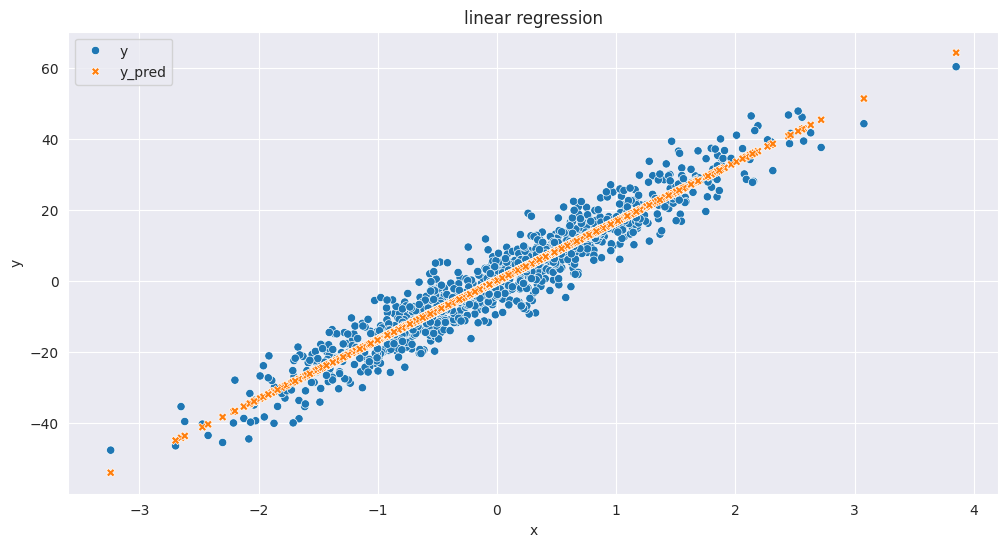

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('linear regression')
plt.xlabel('x')
plt.ylabel('y')

sns.set_style('darkgrid')
sns.scatterplot(data=reg_data)


##1. Регуляризация##
Цель регуляризации заключается в борьбе с сложными моделями. Причем сложность моделей может проявляться в разных вещах. В линейных моделях сложность заключается в больших значениях весов или несбалансированности их абсолютных значений. Например:
$1x_0 + 1000x_1 + 1x_2 = y$ \
По непонятным причинам фича $x_1$ вносит больший вклад в итоговый результат. Такая несбалансированность весов ведет к неустойчивости работы модели. \
\
Мы будем штрафовать модель за большие веса.
###1.1. L1 регуляризация (Lasso регрессия)###
$$loss = MSE + λ_1 \sum_{j = 1}^{m} |\omega_j|$$
Возьмем градиент и получим: \
$$∇(LassoMSE) = \frac{2}{N} (\hat{Y} - Y) X + \lambda_1 sgn(W)$$
$\lambda_1$ — параметр, задающий степень влияния регуляризации на модель, $W$ — вектор весов.

###1.2. L2 регуляризация (Ridge регрессия)###
$$loss = MSE + λ_2 \sum_{j = 1}^{m} \omega_j^{2}$$
Вычислим градиент: \
$$∇(RidgeMSE) = \frac{2}{N} (\hat{Y} - Y) X + 2\lambda_2W$$

###1.3. ElasticNet###
По сути это комбинация регуляризаций L1 и L2:
$$loss = MSE + λ_1 \sum_{j = 1}^{m} |\omega_j| + λ_2 \sum_{j = 1}^{m} \omega_j^{2}$$
Градиент:
$$∇(ElasticNetMSE) = \frac{2}{N} (\hat{Y} - Y) X + \lambda_1 sgn(W) + 2\lambda_2W$$

##2. Stohastic Gradient Descent (SGD)##
Во-первых, выделяют подходы по количеству используемых объектов:

* Классический стохастический градиентный спуск предполагает использование на каждом шаге ровно одного образца из выборки.
* Пакетный подход (Mini-Batch) – на каждом шаге мы используем пакет из небольшого числа элементов обучающей выборки. Это позволяет уменьшить излишнюю “стохастичность” (случайность) градиентного спуска.

Во-вторых, SGD различаются по способу отбора объектов:

* В одном варианте все экземпляры перебираются последовательно. Когда объекты заканчиваются перебор начинается сначала пока не будет достигнуто заданное кол-во итераций.
* В другом варианте на каждом шаге формируется случайная подвыборка элементов.

В нашей реализации мы задействуем случайный отбор заданного количества элементов.